<a href="https://colab.research.google.com/github/lights9/Food-Recognition/blob/main/FoodRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

------------

Download data and mount at google drive

------------



In [ ]:
#! pip install -q kaggle
#from google.colab import files

from google.colab import drive
drive.mount('/content/drive')
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"   # create a folder under MyDrive with the name Kaggle to be able to mount to it and download the dataset from the  commands below

! kaggle datasets list
%cd /content/drive/MyDrive/Kaggle/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ref                                                                title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
victorsoeiro/netflix-tv-shows-and-movies                           Netflix TV Shows and Movies                           2MB  2022-05-15 00:01:23          15494        449  1.0              
ruchi798/data-science-job-salaries                                 Data Science Job Salaries                             7KB  2022-06-15 08:59:12           4271        150  1.0              
zusmani/petrolgas-prices-worldwide                                 Petrol/Gas Prices Worldwide             



---
If data not already downloaded use these commands, before that create a folder under MyDrive with the name Kaggle

---



In [ ]:
#! kaggle datasets download -d kmader/food41
#! mkdir fooddata
#! unzip food41.zip -d fooddata


In [ ]:

os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle/fooddata"
%ls /content/drive/MyDrive/Kaggle/fooddata/images
%cd /content/drive/MyDrive/Kaggle/fooddata/images

apple_pie/           eggs_benedict/            onion_rings/
baby_back_ribs/      escargots/                oysters/
baklava/             falafel/                  pad_thai/
beef_carpaccio/      filet_mignon/             paella/
beef_tartare/        fish_and_chips/           pancakes/
beet_salad/          foie_gras/                panna_cotta/
beignets/            french_fries/             peking_duck/
bibimbap/            french_onion_soup/        pho/
bread_pudding/       french_toast/             pizza/
breakfast_burrito/   fried_calamari/           pork_chop/
bruschetta/          fried_rice/               poutine/
caesar_salad/        frozen_yogurt/            prime_rib/
cannoli/             garlic_bread/             pulled_pork_sandwich/
caprese_salad/       gnocchi/                  ramen/
carrot_cake/         greek_salad/              ravioli/
ceviche/             grilled_cheese_sandwich/  red_velvet_cake/
cheesecake/          grilled_salmon/           risotto/
cheese_plate/     



---


# Data Preparation


---



In [ ]:
# Define library import statements:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import os
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split


#For analyzing the performance
from sklearn.metrics import confusion_matrix, classification_report


#For building the model
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,MaxPool2D, BatchNormalization, Conv2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Model




---


Define path for the directory where everything is stored


---



In [ ]:
image_dir = Path('/content/drive/MyDrive/Kaggle/fooddata/images')



---


Code for a dataframe to contain, one column with all the path files and the other column with all the labels, for each image associated with file path


---



In [ ]:
#Create DataFrame
filepaths = list(image_dir.glob(r'**/*.jpg'))
#print out class name
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

#create samples from each category:
#creating dataframes each of them containing different 100images from each class
#shuffle data
    
category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(100, random_state=1))
    #axis=0 -> on top of each other; frac=1.0 -> sample 100% of the data without replacement
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True) 




---


# Visualize Data


---



In [ ]:
images # filepaths along with label

,Filepath,Label
0,/content/drive/MyDrive/Kaggle/fooddata/images/...,apple_pie
1,/content/drive/MyDrive/Kaggle/fooddata/images/...,apple_pie
2,/content/drive/MyDrive/Kaggle/fooddata/images/...,apple_pie
3,/content/drive/MyDrive/Kaggle/fooddata/images/...,apple_pie
4,/content/drive/MyDrive/Kaggle/fooddata/images/...,apple_pie
...,...,...
100995,/content/drive/MyDrive/Kaggle/fooddata/images/...,waffles
100996,/content/drive/MyDrive/Kaggle/fooddata/images/...,waffles
100997,/content/drive/MyDrive/Kaggle/fooddata/images/...,waffles
100998,/content/drive/MyDrive/Kaggle/fooddata/images/...,waffles


In [ ]:
images.query("Label == 'apple_pie'")

,Filepath,Label
0,/content/drive/MyDrive/Kaggle/fooddata/images/...,apple_pie
1,/content/drive/MyDrive/Kaggle/fooddata/images/...,apple_pie
2,/content/drive/MyDrive/Kaggle/fooddata/images/...,apple_pie
3,/content/drive/MyDrive/Kaggle/fooddata/images/...,apple_pie
4,/content/drive/MyDrive/Kaggle/fooddata/images/...,apple_pie
...,...,...
995,/content/drive/MyDrive/Kaggle/fooddata/images/...,apple_pie
996,/content/drive/MyDrive/Kaggle/fooddata/images/...,apple_pie
997,/content/drive/MyDrive/Kaggle/fooddata/images/...,apple_pie
998,/content/drive/MyDrive/Kaggle/fooddata/images/...,apple_pie


In [ ]:
image_df  #display dataframe where only 100 different images are used for all 101 food classes

,Filepath,Label
0,/content/drive/MyDrive/Kaggle/fooddata/images/...,paella
1,/content/drive/MyDrive/Kaggle/fooddata/images/...,steak
2,/content/drive/MyDrive/Kaggle/fooddata/images/...,bread_pudding
3,/content/drive/MyDrive/Kaggle/fooddata/images/...,waffles
4,/content/drive/MyDrive/Kaggle/fooddata/images/...,french_toast
...,...,...
10095,/content/drive/MyDrive/Kaggle/fooddata/images/...,croque_madame
10096,/content/drive/MyDrive/Kaggle/fooddata/images/...,poutine
10097,/content/drive/MyDrive/Kaggle/fooddata/images/...,breakfast_burrito
10098,/content/drive/MyDrive/Kaggle/fooddata/images/...,guacamole


In [ ]:
image_df['Label'].value_counts()

paella                  100
red_velvet_cake         100
baby_back_ribs          100
shrimp_and_grits        100
cup_cakes               100
                       ... 
takoyaki                100
pad_thai                100
fried_rice              100
strawberry_shortcake    100
apple_pie               100
Name: Label, Length: 101, dtype: int64

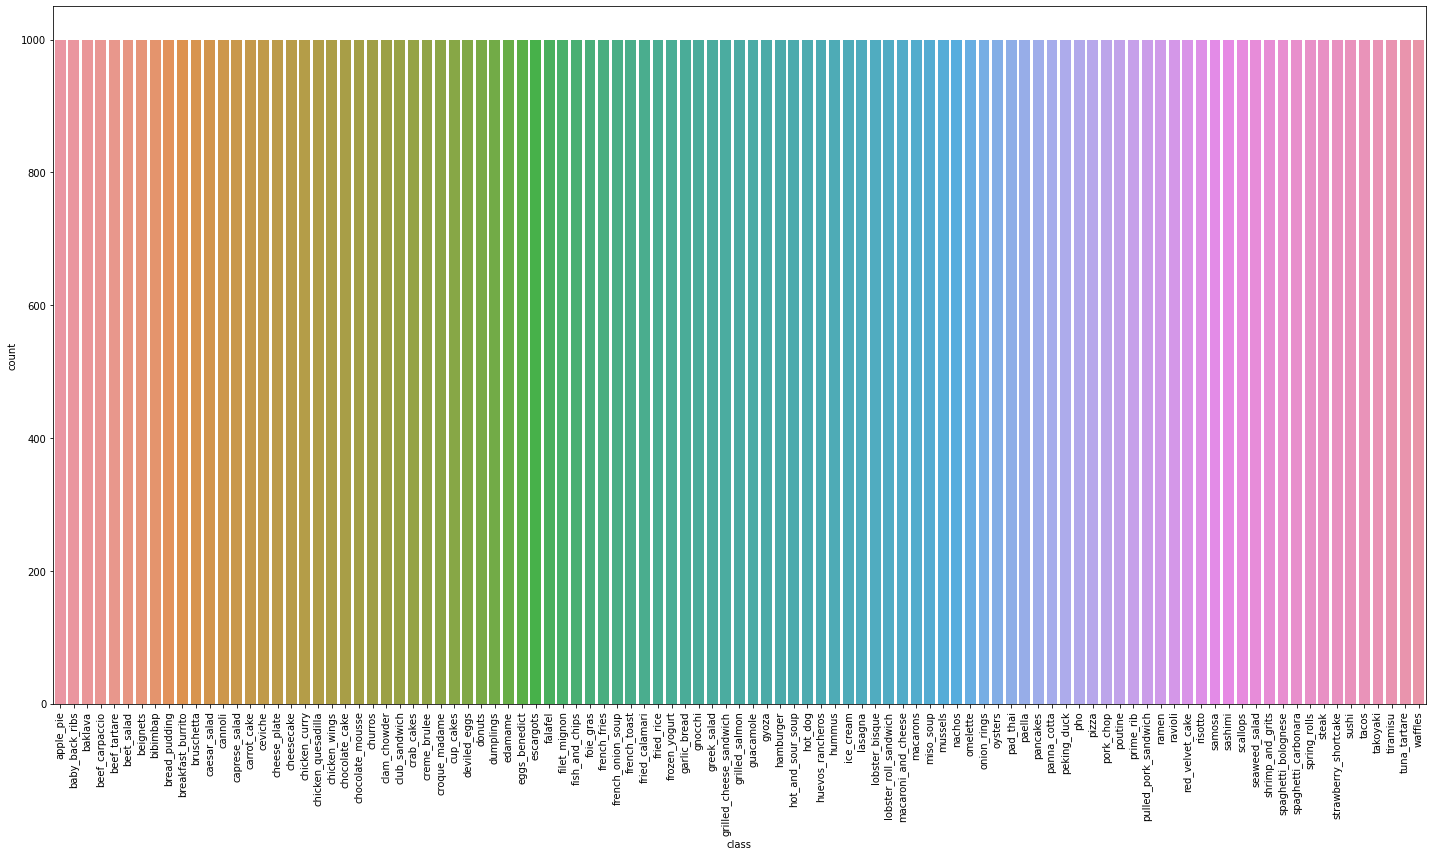

In [ ]:
# count the number of images in each class for the training data
DF = pd.DataFrame(columns=['class','count'])
DF['class']=pd.Series([os.listdir(image_dir)[x] for x in range(0,101)])
DF['count']=pd.Series([len(os.listdir(os.path.join(image_dir,os.listdir(image_dir)[x]))) for x in range(0,101)])
plt.figure(figsize=(20,12))
g=sns.barplot(x='class', y='count',data=DF)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.tight_layout()



---


# TRAIN / TEST / VAL SPLIT 


---



In [ ]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

# Create Generators
# Generators to load images one batch a time, so we don't run out of memory, set batch size
# to 128, load in 128 images, train on those images, then recycle the memory for the next batches so we don't run out

# Apply data Augmentation parameters to the train generator

train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   rotation_range = 0.5,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest',
                                   validation_split=0.2
                                  )

test_val_datagen = ImageDataGenerator(rescale = 1.0/255.0)

batch = 128
img_size=(224,224)

train_images = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical', #since it is a multi-class classification task
    batch_size=batch,  #define here, don't have to define later
    shuffle=True,
    seed=42,  # to reproduce results
    subset='training' # only available if using validation split, specifies if
    # taking 20% val or 80% training
)


# does not have validation split
test_images = test_val_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch,
    shuffle=False
)

val_images = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch,
    shuffle=True,
    seed=42,
    subset='validation'
)

# print in order train,validation,test

Found 5656 validated image filenames belonging to 101 classes.
Found 3030 validated image filenames belonging to 101 classes.
Found 1414 validated image filenames belonging to 101 classes.




---


# Try Pretrained Model: VGG16


---



In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, #defines if the final classifaction layer that the original model was trained on will be kept or not;
                            input_shape=(224, 224,3))

# freeze extraction layers
base_model.trainable = False #ensures that we don't mess up the original net weight

# add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(base_model.output)
predictions = Dense(101, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# confirm unfrozen layers
for layer in model.layers:
    if layer.trainable==True:
        print(layer)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# compile the model
model.compile(
  loss='categorical_crossentropy', #categorical_crossentropy, becuase we used Generators
  optimizer='adam',
  metrics=['accuracy']  #accuracy, because multi-class
)
# print summary of model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# **Model Training**

In [ ]:
history = model.fit(train_images,
                    epochs = 15,
                    validation_data = val_images)

Epoch 1/15
45/45 [==============================] - 159s 3s/step - loss: 5.1352 - accuracy: 0.0624 - val_loss: 4.1990 - val_accuracy: 0.1061
Epoch 2/15
45/45 [==============================] - 121s 3s/step - loss: 3.5387 - accuracy: 0.2252 - val_loss: 3.9177 - val_accuracy: 0.1400
Epoch 3/15
45/45 [==============================] - 121s 3s/step - loss: 3.0474 - accuracy: 0.2981 - val_loss: 3.9712 - val_accuracy: 0.1620
Epoch 4/15
45/45 [==============================] - 122s 3s/step - loss: 2.7896 - accuracy: 0.3575 - val_loss: 3.9181 - val_accuracy: 0.1704
Epoch 5/15
45/45 [==============================] - 121s 3s/step - loss: 2.4994 - accuracy: 0.4054 - val_loss: 3.9691 - val_accuracy: 0.1782
Epoch 6/15
45/45 [==============================] - 123s 3s/step - loss: 2.3166 - accuracy: 0.4392 - val_loss: 4.0235 - val_accuracy: 0.1917
Epoch 7/15
45/45 [==============================] - 120s 3s/step - loss: 2.2697 - accuracy: 0.4646 - val_loss: 4.0340 - val_accuracy: 0.1987
Epoch 8/15
45

In [ ]:
history = model.fit(train_images,
                    epochs = 5,
                    validation_data = val_images)

Epoch 1/5
45/45 [==============================] - 125s 3s/step - loss: 1.4122 - accuracy: 0.6391 - val_loss: 4.0587 - val_accuracy: 0.2044
Epoch 2/5
45/45 [==============================] - 123s 3s/step - loss: 1.2088 - accuracy: 0.6860 - val_loss: 4.1796 - val_accuracy: 0.2284
Epoch 3/5
45/45 [==============================] - 123s 3s/step - loss: 1.1833 - accuracy: 0.6860 - val_loss: 4.1482 - val_accuracy: 0.2100
Epoch 4/5
45/45 [==============================] - 122s 3s/step - loss: 1.1756 - accuracy: 0.6938 - val_loss: 4.2519 - val_accuracy: 0.1987
Epoch 5/5
45/45 [==============================] - 121s 3s/step - loss: 1.1525 - accuracy: 0.6957 - val_loss: 4.1237 - val_accuracy: 0.2235




---


# Results


---



In [ ]:
_, acc = model.evaluate(test_images, steps=len(test_images), verbose=0)
print('Accuracy: %.3f' % (acc * 100.0))



Accuracy: 25.710


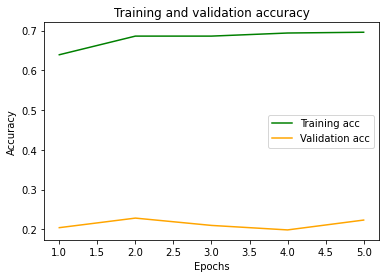

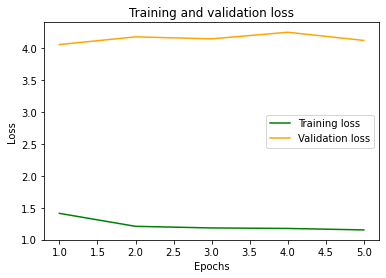

In [ ]:
# Plotting Results
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'green', label='Training acc')
plt.plot(epochs, val_acc, 'orange', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Training and validation accuracy')
plt.legend()
fig = plt.figure()
fig.savefig('acc.png')


plt.plot(epochs, loss, 'green', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [ ]:
import os
#os.makedirs('models/')          # Creating a directory
model.save('models/model.h5')   # Saving model



---


batch = 128
img_size=(224,224), 20 epochs Model VGG16, 35 steps in one epoch , accuracy = ist besser geworden 29.958%

same but with 30 epochs --> accuracy: 28.75 % CLASSES (80 at that time)

Now 15 + 5 epochs same batch 128, img size 224,224
Accuracy: 25.413


---



# Evaluation

---



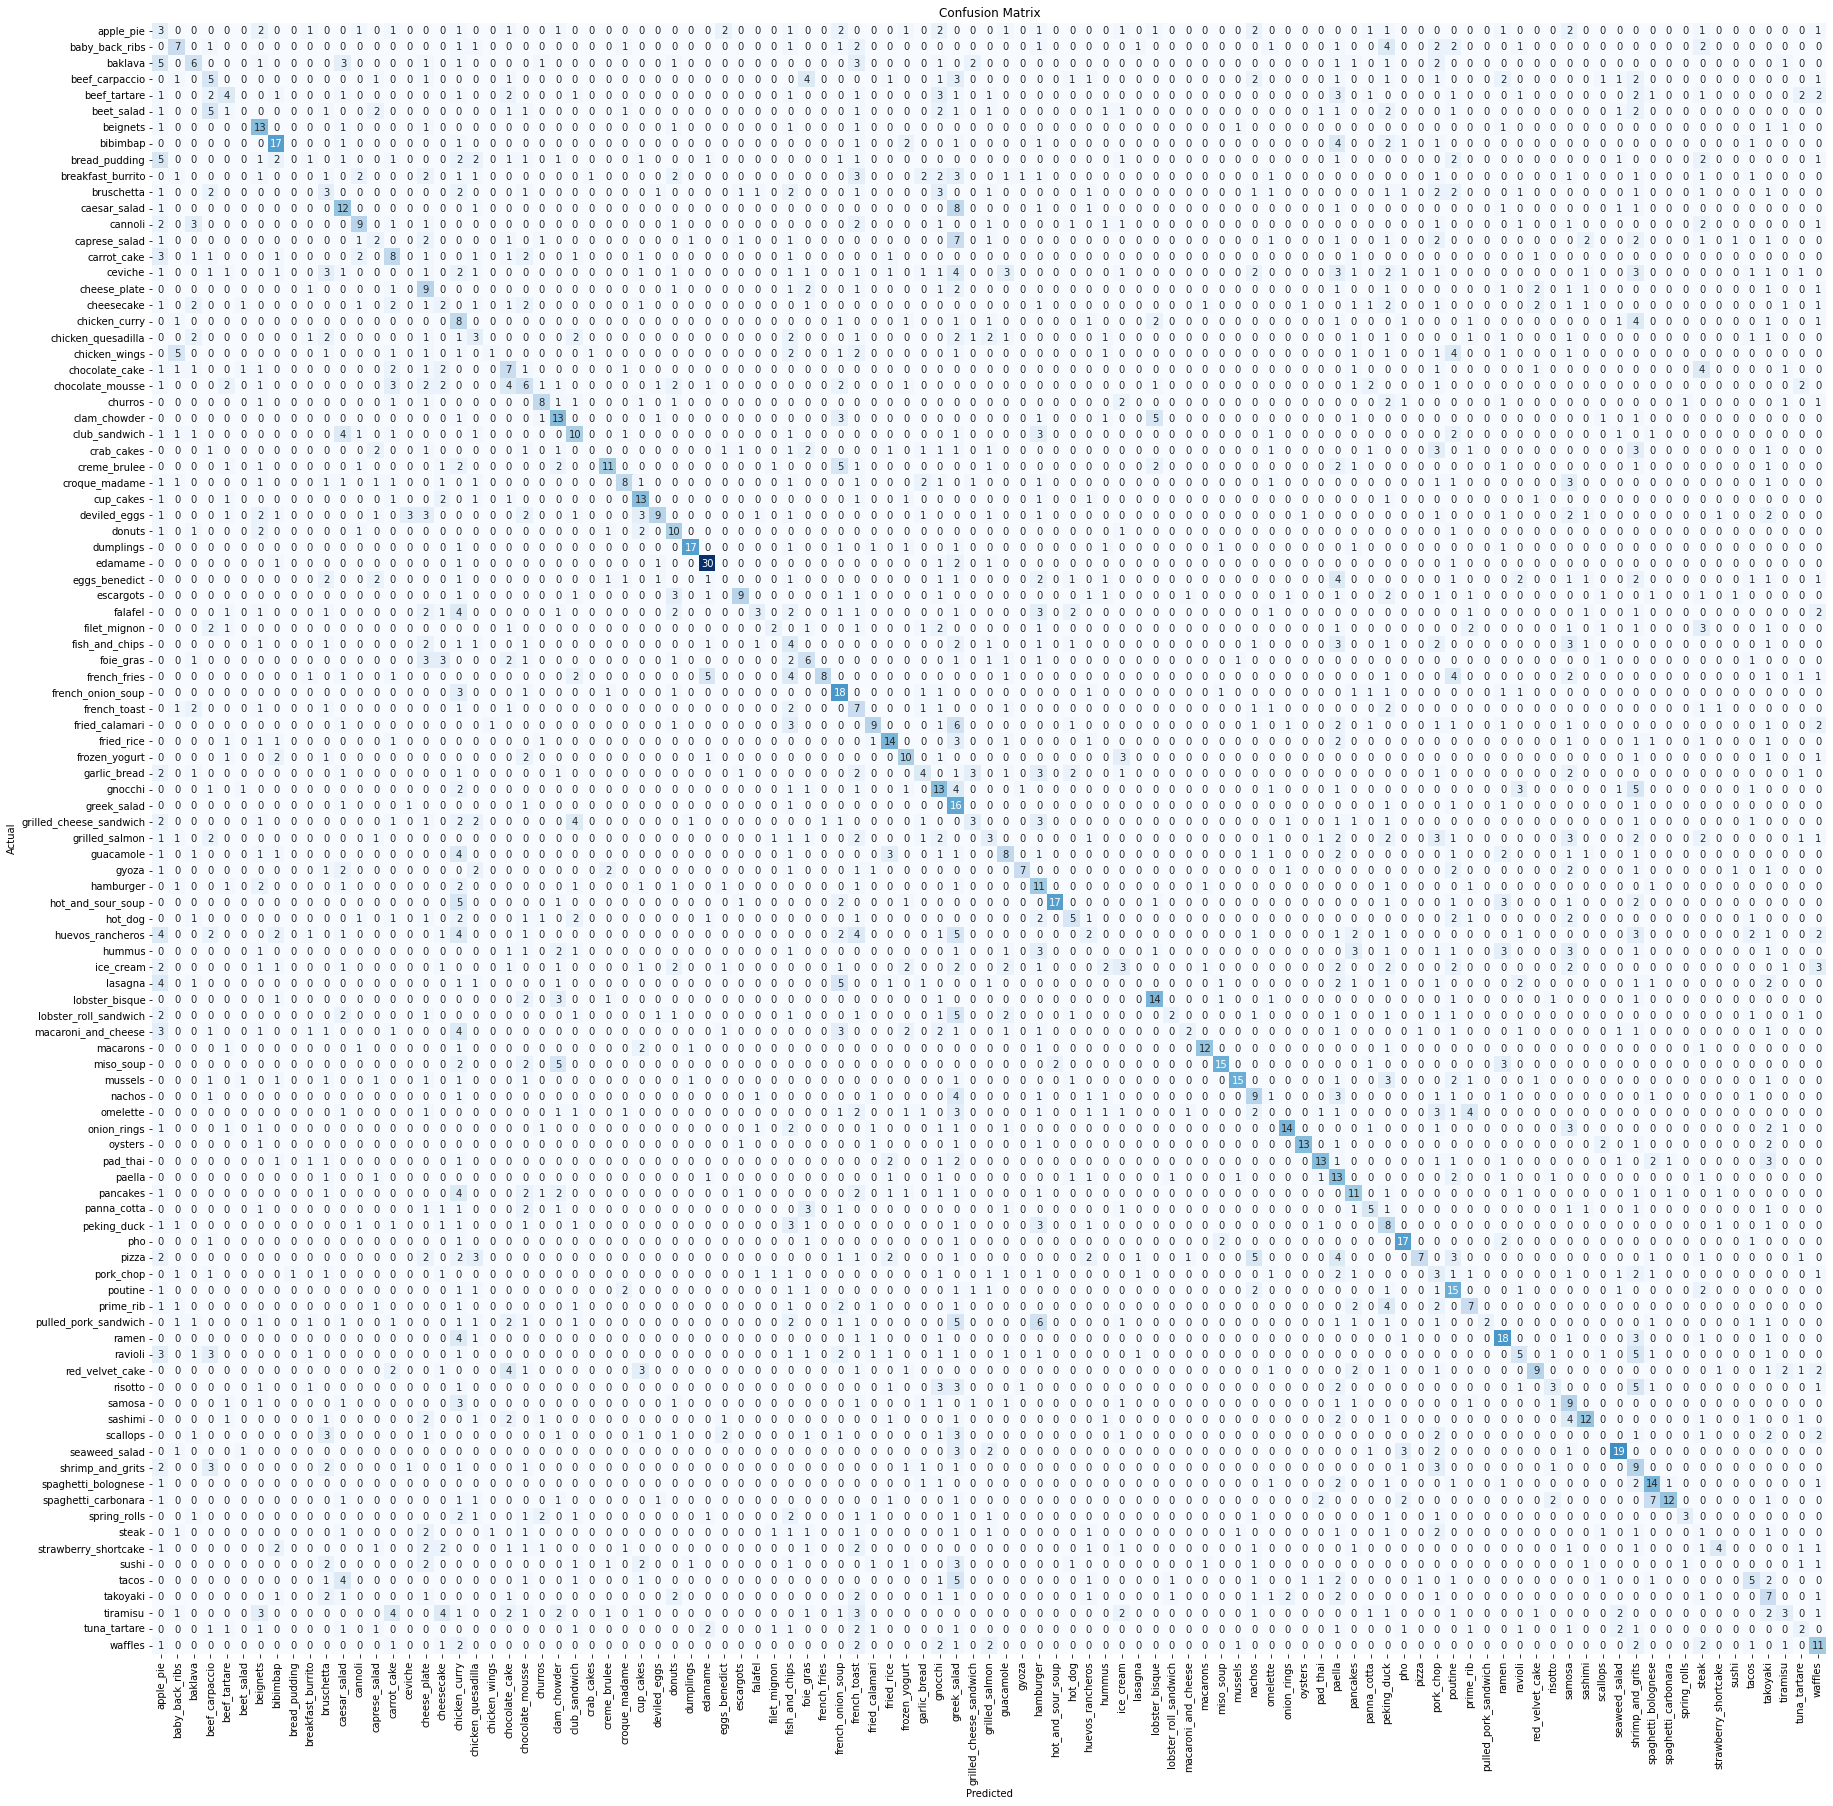

In [ ]:
predictions = np.argmax(model.predict(test_images), axis=1)
cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)


plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                          precision    recall  f1-score   support

              apple_pie       0.04      0.09      0.06        32
         baby_back_ribs       0.25      0.23      0.24        30
                baklava       0.21      0.19      0.20        31
         beef_carpaccio       0.14      0.16      0.14        32
           beef_tartare       0.19      0.12      0.15        34
             beet_salad       0.00      0.00      0.00        28
               beignets       0.27      0.57      0.37        23
               bibimbap       0.46      0.52      0.49        33
          bread_pudding       0.00      0.00      0.00        30
      breakfast_burrito       0.00      0.00      0.00        31
             bruschetta       0.08      0.09      0.09        32
           caesar_salad       0.26      0.43      0.32        28
                cannoli       0.41      0.30      0.35        30
          caprese_salad       0.12      0.